In [1]:
# Test fit to NuSTAR data using standard v7 CHIANTI thermal file
# 
# 22-Sep-2022 IGH
# 07-Nov-2023 Updated during refactoring sunxspex -> sunkit_spex

In [2]:
import numpy as np
from astropy import units as u
import matplotlib
import matplotlib.pyplot as plt
# wip version during refactor
from sunkit_spex.sunxspex_fitting.fitter import Fitter

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
            'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [3]:
spec_single_plot_size = (6,8)
spec_plot_size = (22,8)
spec_font_size = 16
default_font_size = 10
x_limits, y_limits = [1.9,6.1], [9e-2,9e3]

In [4]:
# What spec file are we doing this with?
xsn='319_r60'
mid=xsn[0:3]
timlab='02:07:41+100s'
fiter=[2.5,5.0]
dur=100

fiter1=("{0:4.2f}".format(fiter[0])).lstrip()
fiter2=("{0:4.2f}".format(fiter[1])).lstrip()
fiterlab="{0:3d}{1:3d}".format(int(10*fiter[0]),int(10*fiter[1]))
fiterlab=fiterlab.replace(" ","")

_dir = "/Users/iain/data/mfe_2019/ns_20190425/20511"+mid+"001/event_cl/spec_"+xsn+"/"
spec = Fitter(pha_file=[_dir+"nu20511"+mid+"001A06_sr.pha", 
                          _dir+"nu20511"+mid+"001B06_sr.pha"])

In [5]:
spec.loglikelihood="poisson"
spec.model = "C*f_vth"
spec.energy_fitting_range = fiter
spec.params["C_spectrum1"] = {"Status":"frozen"}

spec.params["T1_spectrum1"] = {"Value":5.0, "Bounds":(3.0, 7.0)}
spec.params["EM1_spectrum1"] = {"Value":1e-1, "Bounds":(0.01, 1.0)}        
spec.params["C_spectrum2"] = {"Status":"free", "Bounds":(0.8, 1.2)}

print(spec.params)

                          Status  Value       Bounds       Error
T1_spectrum1                free    5.0   (3.0, 7.0)  (0.0, 0.0)
EM1_spectrum1               free    0.1  (0.01, 1.0)  (0.0, 0.0)
C_spectrum1               frozen    1.0  (0.0, None)  (0.0, 0.0)
T1_spectrum2    tie_T1_spectrum1    1.0  (0.0, None)  (0.0, 0.0)
EM1_spectrum2  tie_EM1_spectrum1    1.0  (0.0, None)  (0.0, 0.0)
C_spectrum2                 free    1.0   (0.8, 1.2)  (0.0, 0.0)


In [6]:
minimised_params = spec.fit()

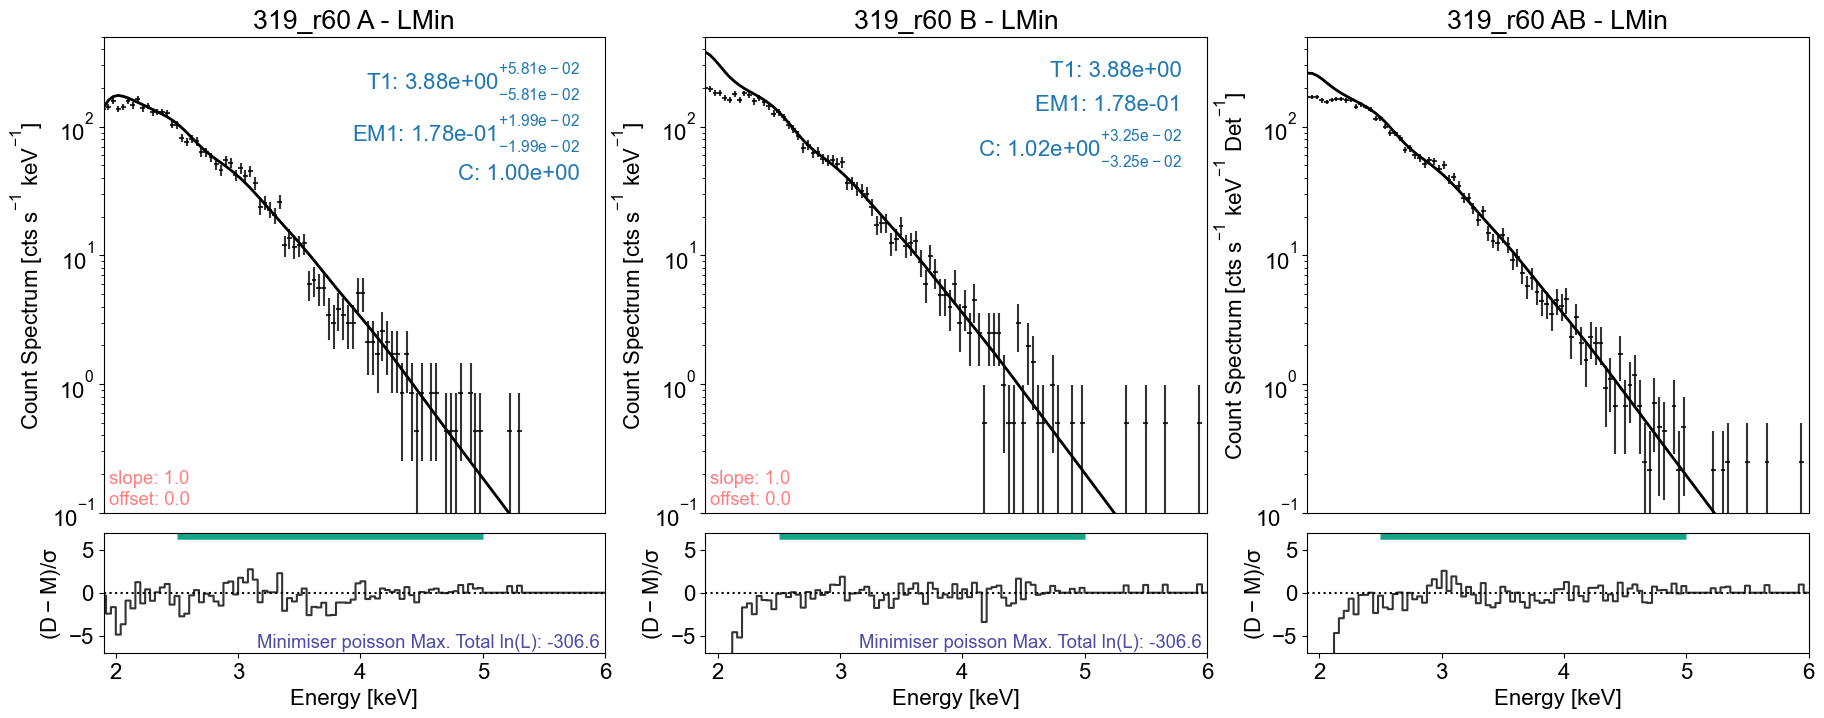

In [7]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
# axes, res_axes = spec.plot(rebin=12)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim([1.9,6.0])
    a.set_ylim([1e-1,5e2])
axes[0].set_title(xsn+' A - LMin')
axes[1].set_title(xsn+' B - LMin')
axes[2].set_title(xsn+' AB - LMin')
plt.show()

plt.rcParams['font.size'] = default_font_size

In [8]:
mcmc_result = spec.run_mcmc(steps_per_walker=1000,walker_spread='mag_order')

100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


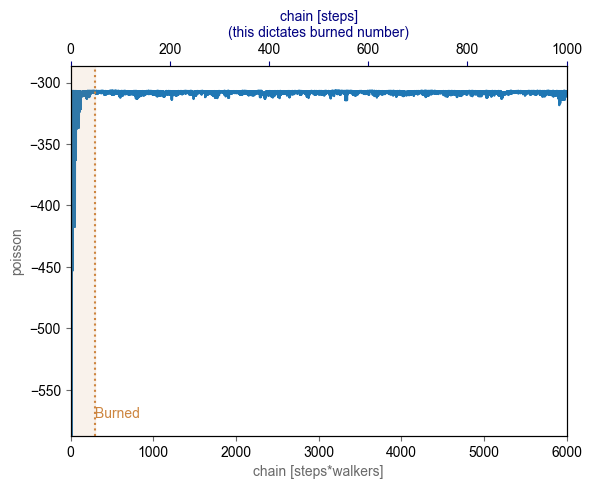

In [9]:
spec.burn_mcmc = 50
plt.figure()
spec.plot_log_prob_chain()
probs=spec.mcmc_sampler.get_log_prob(flat=True)
burn_ylim=[np.min(probs),np.max(probs)+20]
plt.ylim(burn_ylim)
plt.show()

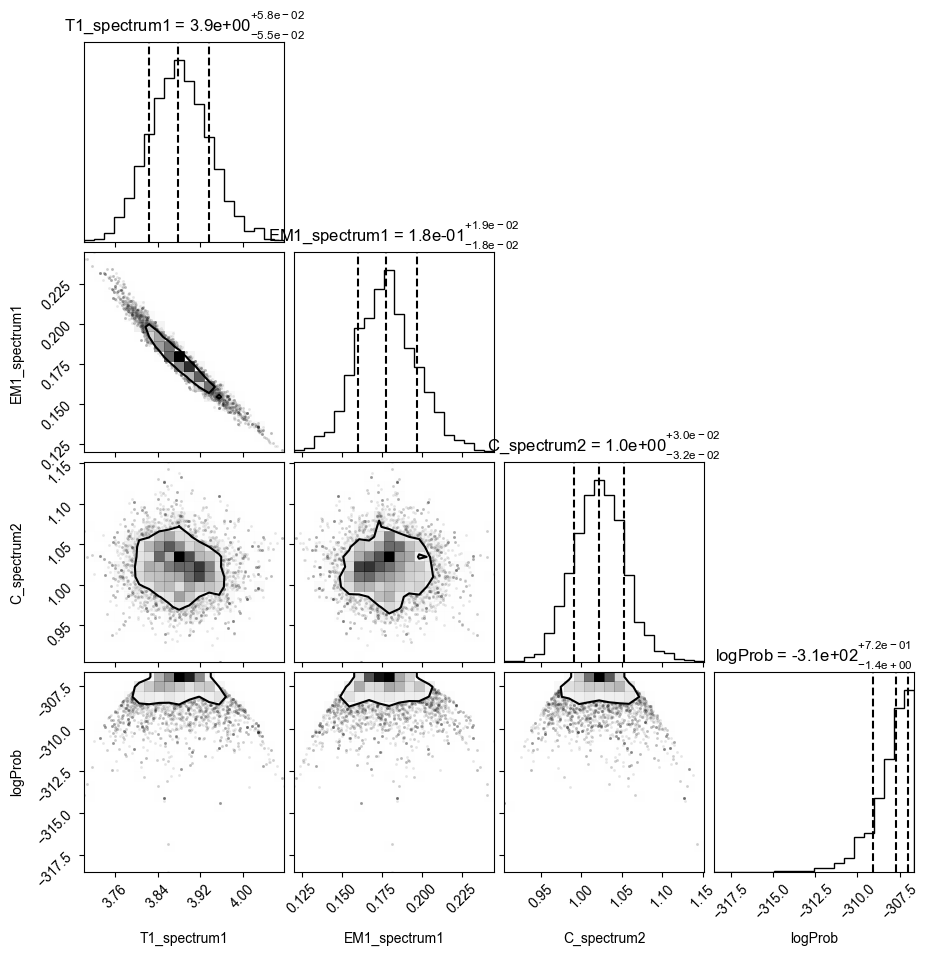

In [10]:
corner_plot = spec.corner_mcmc()
plt.show()

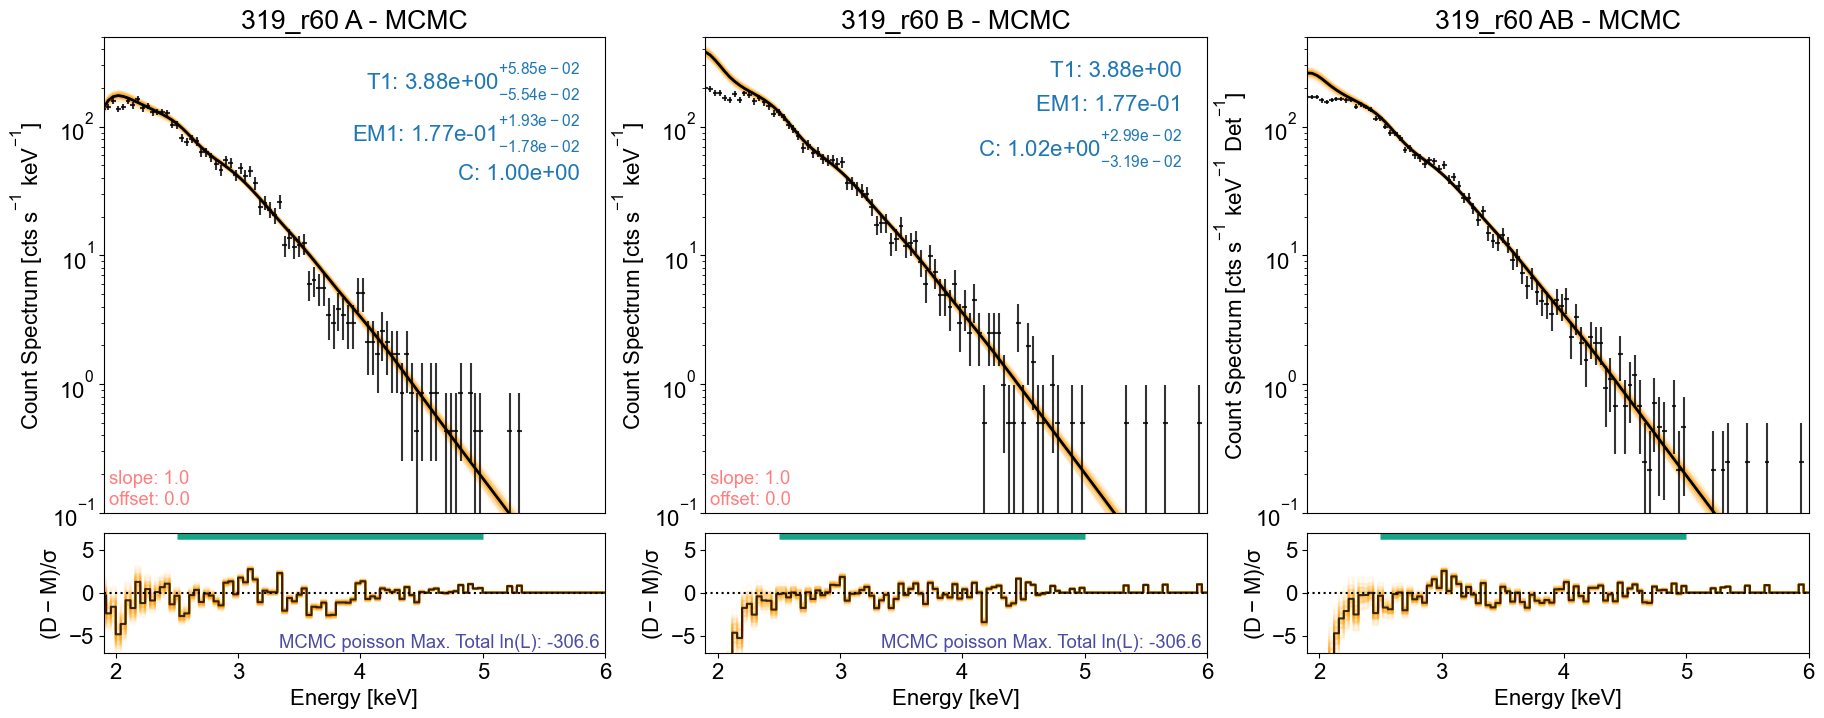

In [11]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=spec_plot_size)
axes, res_axes = spec.plot()
for a in axes:
    a.set_xlim([1.9,6.0])
    a.set_ylim([1e-1,5e2])
axes[0].set_title(xsn+' A - MCMC')
axes[1].set_title(xsn+' B - MCMC')
axes[2].set_title(xsn+' AB - MCMC')
plt.show()

plt.rcParams['font.size'] = default_font_size

In [12]:
# Extract all the data to do the nicer plot
effexpA=spec.data.loaded_spec_data['spectrum1']['effective_exposure']
effexpB=spec.data.loaded_spec_data['spectrum2']['effective_exposure']
effexp=0.5*(effexpA+effexpB)
engs=spec.plotting_info['spectrum1']['count_channels']
edels=spec.plotting_info['spectrum1']['count_channel_error']
rat1=spec.plotting_info['spectrum1']['count_rates']
erat1=spec.plotting_info['spectrum1']['count_rate_errors']
rat2=spec.plotting_info['spectrum2']['count_rates']
erat2=spec.plotting_info['spectrum2']['count_rate_errors']
resid1=spec.plotting_info['spectrum1']['residuals'][::2]
resid2=spec.plotting_info['spectrum2']['residuals'][::2]
# # resid=[ for r in resid]
# # resid=spec.plotting_info['spectrum1']['residuals'][0:len(rat)]
fmd1=spec.plotting_info['spectrum1']['count_rate_model']
fmd2=spec.plotting_info['spectrum2']['count_rate_model']

mca=spec.plotting_info['spectrum1']['mcmc_model_runs']
mcb=spec.plotting_info['spectrum2']['mcmc_model_runs']
# Only one model so can pull out the total
# fmd1=spec.plotting_info['spectrum1']['submodels'][0]
# fmd2=spec.plotting_info['spectrum2']['submodels'][0]
# fmd=fmd[0]
stepe = list()
for i in range(len(engs)):
    stepe.append(engs[i] - edels[i])
stepe.append(engs[-1]+edels[-1])
# fmd1=[fmd1,fmd1[-1]]
# fmd2=[fmd2,fmd2[-1]]

fmd1=fmd1[0:1000]
fmd2=fmd2[0:1000]

fiter=spec.plotting_info['spectrum1']['fitting_range']

tmk=spec.params["T1_spectrum1"]['Value']
tmk_ci=[tmk-spec.params["T1_spectrum1"]['Error'][0],tmk+spec.params["T1_spectrum1"]['Error'][1]]
em=spec.params["EM1_spectrum1"]['Value']*1e46
em_ci=[em-spec.params["EM1_spectrum1"]['Error'][0]*1e46,\
    em+spec.params["EM1_spectrum1"]['Error'][1]*1e46]
fac=spec.params["C_spectrum2"]['Value']
fac_ci=[fac-spec.params["C_spectrum2"]['Error'][0],fac+spec.params["C_spectrum2"]['Error'][1]]

#     ---------------------------------------    
#     Format the fit results nicely for the plot
tmks=f'{tmk:4.2f}'
tmkups=f'{tmk_ci[1]-tmk:4.2f}'
tmkdns=f'{tmk-tmk_ci[0]:4.2f}'
empow=np.floor(np.log10(em))
ems=f'{em/10**empow:4.2f}'
emps=f'{empow:2.0f}'
emups=f'{(em_ci[1]-em)/10**empow:4.2f}'
emdns=f'{(em-em_ci[0])/10**empow:4.2f}'

facs=f'{fac:4.2f}'
facups=f'{fac_ci[1]-fac:4.2f}'
facdns=f'{fac-fac_ci[0]:4.2f}'  



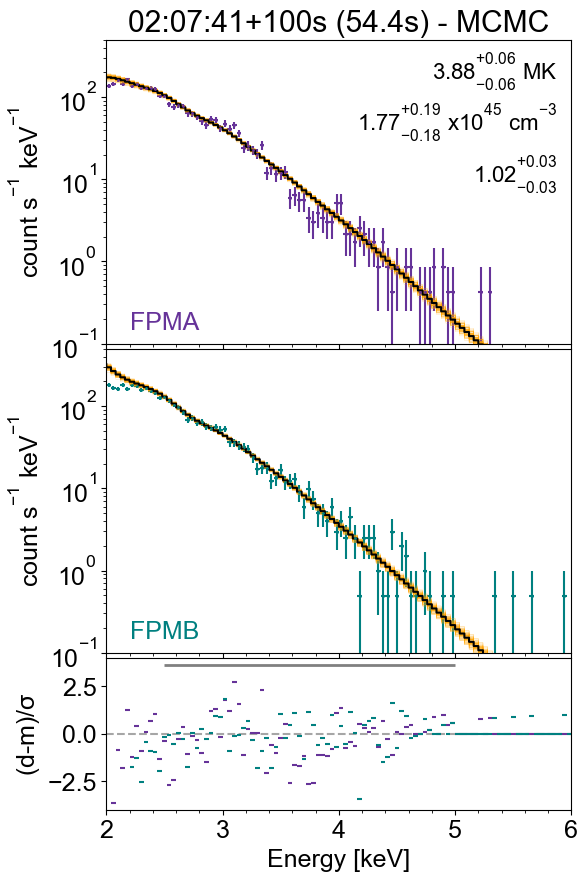

In [13]:
# Do the nicer plot
xlim=[2.,6]
nmax=round(xlim[1]-xlim[0])
ylim=[1e-1,5e2]
yrlim=[-4,4]
clra='rebeccapurple'
clrb='teal'

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

gs_kw = dict( height_ratios=[4,4,2],hspace=0.02,wspace=0.05)
fig, axs = plt.subplots(ncols=1, nrows=3, constrained_layout=False,
                             gridspec_kw=gs_kw,figsize=(6,10))

axs[0].errorbar(engs,rat1,xerr=edels,yerr=erat1,fmt='.',color=clra,lw=1.5,ms=2)
for ma in mca[0]:
    axs[0].step(stepe[0:1000],ma[0:1000],where='post',color='orange',lw=0.1)
axs[0].step(stepe[0:1000],fmd1,where='post',color='k')

axs[1].errorbar(engs,rat2,xerr=edels,yerr=erat2,fmt='.',color=clrb,lw=1.5,ms=2)
for mb in mcb[1]:
    axs[1].step(stepe[0:1000],mb[0:1000],where='post',color='orange',lw=0.1)
axs[1].step(stepe[0:1000],fmd2,where='post',color='k')

axs[2].hlines(0.0,xlim[0],xlim[1],color='grey',linestyle="--",alpha=0.7)
axs[2].hlines(resid1,stepe[0:-1],stepe[1:],color=clra,lw=1.5)
axs[2].hlines(resid2,stepe[0:-1],stepe[1:],color=clrb,lw=1.5)
axs[2].hlines(yrlim[1]*0.9,fiter[0],fiter[1],color='grey',lw=2)

for ax in axs:
    ax.set_xlim(xlim)
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
for ax in axs[0:-1]:
    ax.set_yscale('log')
    ax.set_ylabel('count s$^{-1}$ keV$^{-1}$')
    ax.set_ylim(ylim)
    ax.set_xticklabels([])
    ax.set_xlabel(" ")

axs[2].set_ylabel('(d-m)/$\sigma$')
axs[2].set_xlabel('Energy [keV]')
axs[2].set_ylim(yrlim)
axs[0].set_title(timlab+' ({0:.1f}s) - MCMC'.format(effexp))
axs[0].annotate('FPMA',[xlim[0]*1.1,ylim[0]*1.5],color=clra)
axs[1].annotate('FPMB',[xlim[0]*1.1,ylim[0]*1.5],color=clrb)

# axs[0].text(0.97,0.85,"{0:4.2f} ({1:4.2f},{2:4.2f}) MK".format(tmk,tmk_ci[0],tmk_ci[1]),\
#               color='k',ha='right',transform=axs[0].transAxes)
# axs[0].text(0.97,0.74,"{0:.2e} cm^-3".format(em),\
#               color='k',ha='right',transform=axs[0].transAxes)
# axs[0].text(0.97,0.65,"({0:.2e},{1:.2e})".format(em_ci[0],em_ci[1]),\
#               color='k',ha='right',transform=axs[0].transAxes)
# axs[0].text(0.97,0.54,"{0:4.2f} ({1:4.2f},{2:4.2f})".format(fac,fac_ci[0],fac_ci[1]),\
#               color='k',ha='right',transform=axs[0].transAxes)

axs[0].text(0.97,0.87,tmks+'$^{+'+tmkups+'}_{-'+tmkdns+'}$ MK',\
                  color='k',ha='right',transform=axs[0].transAxes,fontsize=16)
axs[0].text(0.97,0.70,ems+'$^{+'+emups+'}_{-'+emdns+'}$ x10$^{'+emps+'}$ cm$^{-3}$',\
                  color='k',ha='right',transform=axs[0].transAxes,fontsize=16)
axs[0].text(0.97,0.53,facs+'$^{+'+facups+'}_{-'+facdns+'}$',\
                  color='k',ha='right',transform=axs[0].transAxes,fontsize=16)

# plt.savefig(fdir+'sxsAB_pmc_th_'+xsn+'_'+fiterlab+'.pdf',bbox_inches='tight')
plt.show()